In [1]:
import os
from scipy.io import loadmat

src_path = "C:/Users/h1006/Documents/Research/Sun/Code/matlab_output/perturbation_F2/"

#dat_path = src_path + "perturbation analyses for feedforward neural chain/"
dat_path = src_path + "perturbation analyses for comparison with EI connection/"

param_id_EE = ["m", "L", "k1", "k2", "c", "mu_bf", "Ff", "t_max", "w_NE", "w_EN", "w_EE", "w_tE", "w_ES", "w_En",
               "theta_E", "tauE", "theta_N", "tauN", "theta_t", "taut", "theta_S"]
param_id_EI = ["m", "L", "k1", "k2", "c", "mu_bf", "Ff", "t_max", "w_ENd", "w_NE", "w_EN", "w_tE", "w_ES",
               "theta_E", "tauE", "theta_N", "tauN", "theta_t", "taut", "theta_S"]

param_id = param_id_EE
#param_id = param_id_EI

# parameter condition
label1 = "tauE"
val1 = 30
label2 = "tauN"
val2 = 25

# load mat file
dat_name = "EE_Response-{0}-{1}-{2}-{3}.mat".format(label1, str(val1), label2, str(val2))
#dat_name = "EI_Response-{0}-{1}-{2}-{3}.mat".format(label1, str(val1), label2, str(val2))
dat_mat = loadmat(dat_path + dat_name)

print("dat_mat.keys()", dat_mat.keys())
print(dat_name)
for i in range(len(param_id)):
    print("{0}:{1}".format(param_id[i], dat_mat["params"][0][i]))
print("data shape:", dat_mat["v"].shape)

dat_mat.keys() dict_keys(['__header__', '__version__', '__globals__', 'params', 'response', 'v'])
EE_Response-tauE-30-tauN-25.mat
m:0.1
L:0.4
k1:5.3
k2:4.0
c:152000.0
mu_bf:10.0
Ff:0.05
t_max:4.1
w_NE:0.6
w_EN:-2.0
w_EE:1.0
w_tE:1.0
w_ES:1.95
w_En:0.6
theta_E:0.5
tauE:30.0
theta_N:0.55
tauN:25.0
theta_t:0.15
taut:45.0
theta_S:0.8
data shape: (500, 68)


In [2]:
# Analyze mat files

import matplotlib.pyplot as plt
import numpy as np
import peakutils



def kinematics_from_mat(dat):
    
    # Constants
    L_init = 0.4
    index_position = [22 - i*2 for i in range(12)] # adjust indexing
    sec_per_frame = 0.01  # 0.03333 for larva measurement
    
    # Create data of boundary position
    y = []
    for i in range(len(index_position)):
        y.append(dat["v"][:,index_position[i]]*L_init + L_init*i)
    y = np.array(y, dtype="float64").T
    
    # Calculate kinematics from boundary position data
    boundary_num = len(y[0])
    
    # initial position
    initial_disp = []
    for bd in range(boundary_num):
        v0 = y[0,0]  # dat[0,0,:] for vector
        v1 = y[0,bd] # dat[0,bd,:] for vector
        initial_disp.append(v1-v0)
    initial_disp = np.array(initial_disp, dtype="float64")
    
    # displacement_rel
    disp_rel = []
    for bd in range(boundary_num):
        disp_seg = []
        for frame in range(len(y)):
            t = frame * sec_per_frame
            v0 = y[0,0]
            v1 = y[frame,bd]
            disp_seg.append([t, v1-v0])
        disp_rel.append(disp_seg)
    disp_rel = np.array(disp_rel, dtype="float64")
    
    # displacement_abs
    disp_abs = []
    for bd in range(boundary_num):
        disp_abs0 = []
        for frame in range(len(disp_rel[0])):
            t = disp_rel[bd,frame,0]
            disp_abs0.append([t, disp_rel[bd, frame, 1]])
        disp_abs.append(disp_abs0)
    disp_abs = np.array(disp_abs, dtype="float64")
    
    # segment length
    seg_len = []
    for seg in range(boundary_num-1):
        seg_len0 = []
        for frame in range(len(y)):
            t = frame * sec_per_frame
            v0 = y[frame,seg]
            v1 = y[frame,seg+1]
            seg_len0.append([t, v1-v0])
        seg_len.append(seg_len0)
    seg_len = np.array(seg_len, dtype="float64")
    
    # body length
    body_len = []
    for frame in range(len(y)):
        t = frame * sec_per_frame
        v0 = y[frame,0]
        v1 = y[frame,boundary_num-1]
        body_len.append([t, v1-v0])
    body_len = np.array(body_len, dtype="float64")
    
    # segment length
    seg_len_peaks = []
    seg_len_range = []
    
    # find peaks
    for seg in range(len(seg_len)):
        dat0 = seg_len[seg]
        peaks_id_p = peakutils.indexes(dat0[:,1], thres=0.2, min_dist=100)
        peaks_id_n = peakutils.indexes(-dat0[:,1], thres=0.2, min_dist=100)
        seg_len_peaks.append([peaks_id_p, peaks_id_n])
    
    # measure length
    for seg in range(len(seg_len)):
        dat0 = seg_len[seg]
        dat_peaks = seg_len_peaks[seg]
        
        dst_p = [dat0[dat_peaks[0],0], dat0[dat_peaks[0],1]]
        dst_n = [dat0[dat_peaks[1],0], dat0[dat_peaks[1],1]]
        seg_len_range.append([dst_p, dst_n])
        
    return y, initial_disp, disp_rel, disp_abs, seg_len, body_len, seg_len_peaks, seg_len_range

y, initial_disp, disp_rel, disp_abs, seg_len, body_len, seg_len_peaks, seg_len_range = kinematics_from_mat(dat_mat)

print("y.shape:", y.shape)
print("initial_disp.shape:", initial_disp.shape)
print("disp_rel.shape:", disp_rel.shape)
print("disp_abs.shape:", disp_abs.shape)
print("seg_len.shape:", seg_len.shape)
print("body_len.shape:", body_len.shape)
print("len(seg_len_peaks):", len(seg_len_peaks))
print("len(seg_len_range):", len(seg_len_range))

y.shape: (500, 12)
initial_disp.shape: (12,)
disp_rel.shape: (12, 500, 2)
disp_abs.shape: (12, 500, 2)
seg_len.shape: (11, 500, 2)
body_len.shape: (500, 2)
len(seg_len_peaks): 11
len(seg_len_range): 11


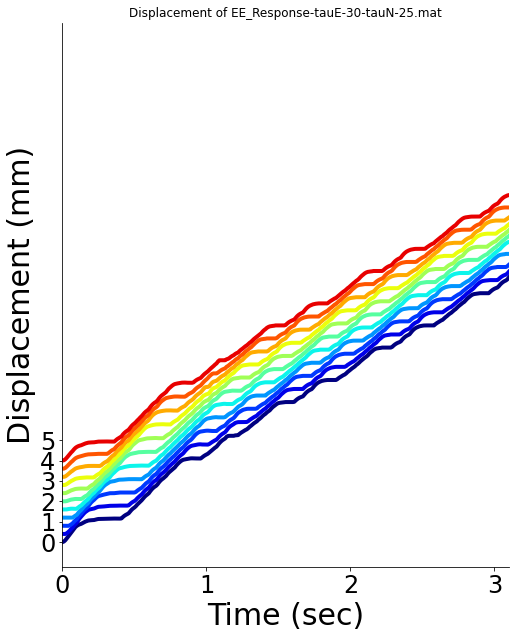

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig_path = "C:/Users/h1006/Documents/Research/Sun/Code/matlab_output/img/"

fig, ax = plt.subplots(figsize = (8,10))
for i in range(len(disp_abs)-1):
    ax.plot(disp_abs[i,:,0], disp_abs[i,:,1], color=cm.jet(i/11), linewidth=4,
           label="x{}".format(10-i))
ax.set_title("Displacement")
ax.set_xlabel("Time (sec)", fontsize=30)
ax.set_ylabel("Displacement (mm)", fontsize=30)
ax.set_title("Displacement of {}".format(dat_name))
plt.xlim([0,3.1])
#plt.ylim([0,6])
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3,4,5])
plt.tick_params(labelsize=24)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.savefig(fig_path + "Displacement_of_{}.png".format(dat_name), facecolor="white", bbox_inches = "tight")

# Parameter extraction

In [4]:
import peakutils
from scipy.signal import argrelmax
from sklearn.linear_model import LinearRegression


def stride_length_fn(disp_abs):
    
    xmin = 0
    xmax = 40
    bins = 800
    width = (xmax-xmin)/bins
    
    stride_position = []
    for i in range(len(disp_abs)):
        stride_seg0 = []
        hist_dat = np.histogram(disp_abs[i,:,1], bins=bins, range=(xmin,xmax))
        peaks_id = peakutils.indexes(hist_dat[0], thres=0.2, min_dist=5)
        peaks_id = np.sort(peaks_id)
        peaks = hist_dat[1][peaks_id]
        for peak_id in range(len(peaks)):
            dat0 = disp_abs[i]
            disp_peak = [dat0[i,1] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            time_peak = [dat0[i,0] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            disp_peak_med = np.median(disp_peak)
            time_peak_med = np.median(time_peak)
            stride_seg0.append([time_peak_med, disp_peak_med])
        stride_position.append(np.array(stride_seg0))
        
    stride_len_seg = []
    for bd in range(len(stride_position)):
        dat_stride = stride_position[bd]
        dst0 = []
        for i in range(len(dat_stride)-1):
            dst0.append(dat_stride[i+1,1]-dat_stride[i,1])
        stride_len_seg.append(np.median(dst0))
        
    return np.median(stride_len_seg)

def boundary_stride_duration_fn(disp_abs):

    sec_per_frame = 0.01
    estimated_delay = []
    for bd in range(len(disp_abs)):
        sig0 = np.diff(disp_abs[bd][:,1])
        sig1 = np.diff(disp_abs[bd][:,1])
        
        # centralization
        sig0 = sig0 - sig0.mean()
        sig1 = sig1 - sig1.mean()
        corr = np.correlate(sig1, sig0, "full")
        
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0):], thres=0.2, min_dist=20)
        estimated_delay.append(peaks_id[0] * sec_per_frame)
    
    return np.median(estimated_delay)
    
def interboundary_delay_fn(disp_abs):
    
    sec_per_frame = 0.01
    interbd_delay = []
    for bd in range(len(disp_abs)-1):
        sig0 = np.diff(disp_abs[bd][:,1])
        sig1 = np.diff(disp_abs[bd+1][:,1])
        
        # centralization
        sig0 = sig0 - sig0.mean()
        sig1 = sig1 - sig1.mean()
        corr = np.correlate(sig1, sig0, "full")
        t_margin = 2
        
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0)-t_margin:], thres=0.2, min_dist=20)
        peaks_id = peaks_id - t_margin
        interbd_delay.append(peaks_id[0] * sec_per_frame)
    
    return interbd_delay
    
def speed_fn(disp_abs):
    
    dst = []
    for bd in range(len(disp_abs)):
        lr = LinearRegression()
        X = disp_abs[bd,:,0].reshape(-1,1)
        Y = disp_abs[bd,:,1].reshape(-1,1)
        lr.fit(X, Y)
        dst.append(lr.coef_[0][0])
    
    return np.median(dst)

def segment_length_range_fn(seg_len_range):
    dst = []
    for seg in range(len(seg_len_range)):
        dat = seg_len_range[seg]
        dst_max = dat[0][1].max()
        dst_min = dat[1][1].min()
        dst.append([dst_max, dst_min])
    
    return np.array(dst)

def contraction_duration_fn(seg_len, seg_len_range, segment_length_range):
    
    valley_id = 2
    
    dst = []
    for seg in range(len(seg_len)):
        dat_time = seg_len[seg][:,0]
        dat_length = seg_len[seg][:,1]
        valley_point = seg_len_range[seg][1][0][valley_id]
        idx = np.where(dat_time == valley_point)[0]
        max_len = segment_length_range[seg][0]
        min_len = segment_length_range[seg][1]
        thrd = (max_len - min_len)*0.5 + min_len
        
        # search for left idx
        left_ = 0
        while(dat_length[idx-left_]<thrd):
            left_ += 1
        idx_left = idx - left_
        
        # search for right idx
        right_ = 0
        while(dat_length[idx+right_]<thrd):
            right_ += 1
        idx_right = idx + right_

        time_left = dat_time[idx_left]
        time_right = dat_time[idx_right]
        
        dst.append(time_right - time_left)
    
    return np.array(dst)



stride_length = stride_length_fn(disp_abs)
print("stride length: {0:.3f} mm".format(stride_length))

boundary_stride_duration = boundary_stride_duration_fn(disp_abs)
print("boundary stride duration: {0:.3f} sec".format(boundary_stride_duration))
    
interboundary_delay = interboundary_delay_fn(disp_abs)
print("interboundary delay (sec):", interboundary_delay)

speed = speed_fn(disp_abs)
print("speed (mm/sec): {0:.3f}".format(speed))

segment_length_range = segment_length_range_fn(seg_len_range)
print("segment length range [max, min] for each segment (mm):", segment_length_range)

contraction_duration = contraction_duration_fn(seg_len, seg_len_range, segment_length_range)
print("contraction duration for each segment (sec):", contraction_duration)


stride length: 0.726 mm
boundary stride duration: 1.060 sec
interboundary delay (sec): [0.09, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
speed (mm/sec): 0.687
segment length range [max, min] for each segment (mm): [[0.4657538  0.04117473]
 [0.46484577 0.04097921]
 [0.4648464  0.0405186 ]
 [0.46490098 0.04132604]
 [0.46494349 0.04126339]
 [0.46499829 0.04125692]
 [0.46506941 0.04124802]
 [0.46513513 0.04127231]
 [0.46520978 0.04300405]
 [0.46850948 0.04167819]
 [0.47387705 0.0416491 ]]
contraction duration for each segment (sec): [[0.15]
 [0.15]
 [0.15]
 [0.15]
 [0.14]
 [0.15]
 [0.15]
 [0.15]
 [0.15]
 [0.14]
 [0.15]]
